In [1]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
from loader import load_data
import scipy.stats as stats
import arviz as az
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
sns.set_theme()

from IPython.display import display, Markdown
az.style.use('arviz-darkgrid')
np.random.seed(44)

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
plt.rcParams['font.size'] = 11
plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams.update({
    "figure.figsize": [8, 4],
    'figure.constrained_layout.use': True,
    'font.size': 11.0,
    'hist.bins': 'auto',
    'lines.linewidth': 3.0,
    'lines.markeredgewidth': 2.0,
    'lines.markerfacecolor': 'none',
    'lines.markersize': 8.0, 
})

In [3]:
df = load_data(r"/Users/christian/supsi/6th sem/bayesian_retry/data_hockey")
df = df.loc[df.Resultat != " -:-"].reset_index(drop=True)
df

,Tag,Datum,Zeit,Home,Away,Resultat,Drittel,OT/SO,Status,Versch.,Stadion,Zus.,Id,Liga,Region,Phase,TV/Online
0,Mi,09.09.2015,19:45,ZSC Lions,SC Bern,5:3,1:0|2:3|2:0,NaN,Ende,False,"Hallenstadion AG, Zürich",9038,20161105071114,NL A,CH,Regular Season,NaN
1,Fr,11.09.2015,19:45,SC Bern,SCL Tigers,7:1,1:0|4:1|2:0,NaN,Ende,False,"PostFinance-Arena, Bern",17031,20161105071001,NL A,CH,Regular Season,NaN
2,Fr,11.09.2015,19:45,HC Davos,Fribourg-Gottéron,4:5,1:0|1:3|2:1|0:1,SO,Ende,False,"Vaillant Arena, Davos",4488,20161105071002,NL A,CH,Regular Season,NaN
3,Fr,11.09.2015,19:45,Genève-Servette HC,HC Ambri-Piotta,8:2,1:2|4:0|3:0,NaN,Ende,False,"Les Vernets, Genève",5804,20161105071003,NL A,CH,Regular Season,NaN
4,Fr,11.09.2015,19:45,EHC Kloten,EHC Biel-Bienne,3:7,2:1|0:3|1:3,NaN,Ende,False,"SWISS Arena, Kloten",4152,20161105071004,NL A,CH,Regular Season,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2445,Sa,23.04.2022,20:00,EV Zug,ZSC Lions,1:2,1:0|0:0|0:2,NaN,Ende,False,"BOSSARD Arena, 6303 Zug",7200,20221105000413,NL,CH,Playoff Final,"SRF,RTS,RSI,MYSPORTS"
2446,Mo,25.04.2022,20:00,ZSC Lions,EV Zug,1:4,1:1|0:1|0:2,NaN,Ende,False,"Hallenstadion, 8050 Zürich ZH",11200,20221105000414,NL,CH,Playoff Final,"SRF,RTS,RSI,MYSPORTS"
2447,Mi,27.04.2022,20:00,EV Zug,ZSC Lions,4:1,0:0|1:1|3:0,NaN,Ende,False,"BOSSARD Arena, 6303 Zug",7200,20221105000415,NL,CH,Playoff Final,"SRF,RTS,RSI,MYSPORTS"
2448,Fr,29.04.2022,20:00,ZSC Lions,EV Zug,0:2,0:1|0:0|0:1,NaN,Ende,False,"Hallenstadion, 8050 Zürich ZH",11200,20221105000416,NL,CH,Playoff Final,"SRF,RTS,RSI,MYSPORTS"


# Preprocessing

In [4]:
# Get unique team names
teams = pd.concat([df["Home"], df["Away"]]).unique()

# Create a new DataFrame for one-hot encoding
encoded_df = pd.DataFrame(index=df.index)

# Create a column for each team and set default value to 0
for team in teams:
    encoded_df[team] = 0

# Mark the corresponding team column with 1
for i, row in df.iterrows():
    encoded_df.at[i, row["Home"]] = 1
    encoded_df.at[i, row["Away"]] = 1

# Concatenate the original DataFrame with the encoded columns
result_df = pd.concat([df, encoded_df], axis=1)

result_df['Datum'] = pd.to_datetime(result_df['Datum'], format='%d.%m.%Y')


for team in teams:
    team_subset = result_df[result_df[team] == 1].copy()
    team_subset.loc[:, team] = team_subset['Datum'].diff().dt.days - 1
    result_df.update(team_subset)


result_df['Home_rest_days'] = result_df.apply(lambda x: x[x['Home']], axis=1)
result_df['Away_rest_days'] = result_df.apply(lambda x: x[x['Away']], axis=1)
result_df.reset_index(drop=True, inplace=True)

In [5]:
# Convert the 'Datum' column to datetime
result_df['Datum'] = pd.to_datetime(result_df['Datum'], format='%d.%m.%Y')


# Split the Resultat into home and away goals
result_df['Home_goals'] = result_df['Resultat'].str.split(':').str[0].astype(int)
result_df['Away_goals'] = result_df['Resultat'].str.split(':').str[1].astype(int)

# Create a new dataframe in the Spotify format
home_df = result_df[['Home', 'Away', 'Home_goals', 'Home_rest_days']]
away_df = result_df[['Away', 'Home', 'Away_goals', 'Away_rest_days']]

hockey_df = pd.concat([home_df, away_df]).sort_values(by="Home").reset_index(drop=True).fillna(0)
hockey_df

,Home,Away,Home_goals,Home_rest_days,Away_goals,Away_rest_days
0,EHC Biel-Bienne,Genève-Servette HC,7.0,3.0,0.0,0.0
1,EHC Biel-Bienne,Lausanne HC,1.0,2.0,0.0,0.0
2,EHC Biel-Bienne,HC Davos,0.0,0.0,2.0,2.0
3,EHC Biel-Bienne,ZSC Lions,1.0,5.0,0.0,0.0
4,EHC Biel-Bienne,EV Zug,4.0,3.0,0.0,0.0
...,...,...,...,...,...,...
4895,ZSC Lions,HC Davos,5.0,1.0,0.0,0.0
4896,ZSC Lions,HC Ambri-Piotta,0.0,0.0,2.0,1.0
4897,ZSC Lions,Fribourg-Gottéron,1.0,4.0,0.0,0.0
4898,ZSC Lions,EHC Kloten,3.0,1.0,0.0,0.0


In [6]:
# Scores for 'HC Lugano' when they played at home
hcl_home_scores = hockey_df[hockey_df['Home'] == 'HC Lugano']['Home_goals'].tolist()

# Scores for 'HC Lugano' when they played away
hcl_away_scores = hockey_df[hockey_df['Away'] == 'HC Lugano']['Away_goals'].tolist()

hockey_df['home_team_code'] = hockey_df['Home'].astype('category').cat.codes

print(hcl_home_scores)
print(hcl_away_scores)
# 691.0
# 542.0

# Create new dataframes for home and away games, now also include days_of_rest
home_df = hockey_df[['Home', 'Home_goals', 'Home_rest_days']].rename(columns={'Home':'Team', 'Home_goals':'Goals', 'Home_rest_days':'days_of_rest'})
away_df = hockey_df[['Away', 'Away_goals', 'Away_rest_days']].rename(columns={'Away':'Team', 'Away_goals':'Goals', 'Away_rest_days':'days_of_rest'})

# Concatenate these dataframes
flattened_df = pd.concat([home_df, away_df], axis=0).reset_index(drop=True)

# Assign a numerical code to each team
flattened_df['team_code'] = flattened_df['Team'].astype('category').cat.codes

flattened_df

[0.0, 2.0, 6.0, 0.0, 2.0, 0.0, 4.0, 8.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 3.0, 0.0, 0.0, 3.0, 3.0, 0.0, 0.0, 3.0, 6.0, 4.0, 3.0, 3.0, 5.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 3.0, 3.0, 0.0, 0.0, 0.0, 1.0, 0.0, 3.0, 0.0, 5.0, 0.0, 0.0, 4.0, 3.0, 4.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 2.0, 5.0, 2.0, 3.0, 1.0, 6.0, 2.0, 5.0, 0.0, 2.0, 5.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 4.0, 4.0, 5.0, 0.0, 5.0, 0.0, 0.0, 3.0, 0.0, 0.0, 3.0, 1.0, 0.0, 4.0, 1.0, 3.0, 1.0, 0.0, 0.0, 3.0, 0.0, 6.0, 2.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 7.0, 4.0, 2.0, 0.0, 1.0, 0.0, 0.0, 3.0, 4.0, 0.0, 1.0, 4.0, 2.0, 7.0, 0.0, 4.0, 0.0, 2.0, 0.0, 0.0, 3.0, 0.0, 4.0, 2.0, 3.0, 0.0, 0.0, 2.0, 0.0, 3.0, 5.0, 0.0, 6.0, 0.0, 2.0, 0.0, 0.0, 1.0, 2.0, 3.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 4.0, 6.0, 1.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 2.0, 7.0, 0.0, 0.0, 0.0, 5.0, 0.0, 4.0, 1.0, 0.0, 6.0, 7.0, 6.0, 2.0, 0.0, 0.0, 0.0, 3.0, 3.0, 5.0, 3.0, 0.0, 5.0, 0.0, 6.0, 3.0, 0.0, 4.0, 1.0,

,Team,Goals,days_of_rest,team_code
0,EHC Biel-Bienne,7.0,3.0,0
1,EHC Biel-Bienne,1.0,2.0,0
2,EHC Biel-Bienne,0.0,0.0,0
3,EHC Biel-Bienne,1.0,5.0,0
4,EHC Biel-Bienne,4.0,3.0,0
...,...,...,...,...
9795,HC Davos,0.0,0.0,7
9796,HC Ambri-Piotta,2.0,1.0,6
9797,Fribourg-Gottéron,0.0,0.0,3
9798,EHC Kloten,0.0,0.0,1


# Pooled model

# Research question
todo

# Setup

todo

# Background information to set the prior
From a research we found the mean goals per game is 7.2. Given this we can divide the score between the two teams, resulting in a mean of 3.6 goals per team in one game.

Extreme values of goals are 0 and 8. A plausible value of standard deviation in the population is thus   (3.6 - 0)/2 = 1.8.

We know that:
$$
\frac{alpha}{beta} = mu
$$
$$
\frac{alpha}{beta^2} = sigma^2
$$

therefore we can calculate alpha and beta as:
$$
alpha = \frac{mu^2}{sigma^2}
$$
$$
beta = \frac{mu}{sigma^2}
$$

In [7]:
mu = 2.75
sigma = 1.37

alpha = mu**2 / sigma**2
beta = mu / sigma**2
alpha, beta

(4.029250359635569, 1.4651819489583886)

# Prior for $\mu_{\text{home}}$ and $\mu_{\text{away}}$

$$
\mu_{\text{teams}}   \sim  Gam(4.03,1.47)
$$
$$
\mu_{\text{rest}}   \sim  N(0,1)
$$

We can model the expected goals like this:
$$
expected\_goals = \mu_{\text{teams}} + \mu_{\text{rest}} * true\_days\_rest
$$

We assign the same priors to both groups, so that we are not favoring a group over another a priori.



# Pooled model with predictive distribution
Our probabilistic model has this format:
$$
\mu \sim Gam(4.03,1.47) 
$$
$$
\vec{y} \sim Po(\lambda=expected\_goals)
$$


In [8]:
avg_days_of_rest = flattened_df['days_of_rest'].mean()
with pm.Model() as pooled_model:
    # Priors
    mu_teams = pm.Gamma('mu_teams', alpha, beta) # One parameter for all teams

    # Prior for the days of rest effect
    beta_days_of_rest = pm.Normal('beta_days_of_rest', mu=0, sigma=1)

    # Expected mean goals, influenced by days of rest
    expected_goals = mu_teams + beta_days_of_rest * flattened_df['days_of_rest'].values

    # Likelihood
    y = pm.Poisson('y', mu=expected_goals, observed=flattened_df['Goals'])
    
    pred_specific_team_avg_rest = pm.Poisson('predictive', mu=mu_teams + beta_days_of_rest * avg_days_of_rest)
    
    # Sampling
    trace_pooled = pm.sample(init="adapt_diag", return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [beta_days_of_rest, mu_teams]
>Metropolis: [predictive]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The number of effective samples is smaller than 25% for some parameters.


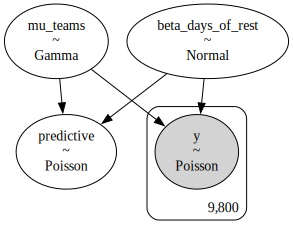

In [9]:
pm.model_to_graphviz(pooled_model)

array([[<AxesSubplot: title={'center': 'beta_days_of_rest'}>,
        <AxesSubplot: title={'center': 'beta_days_of_rest'}>],
       [<AxesSubplot: title={'center': 'predictive'}>,
        <AxesSubplot: title={'center': 'predictive'}>],
       [<AxesSubplot: title={'center': 'mu_teams'}>,
        <AxesSubplot: title={'center': 'mu_teams'}>]], dtype=object)

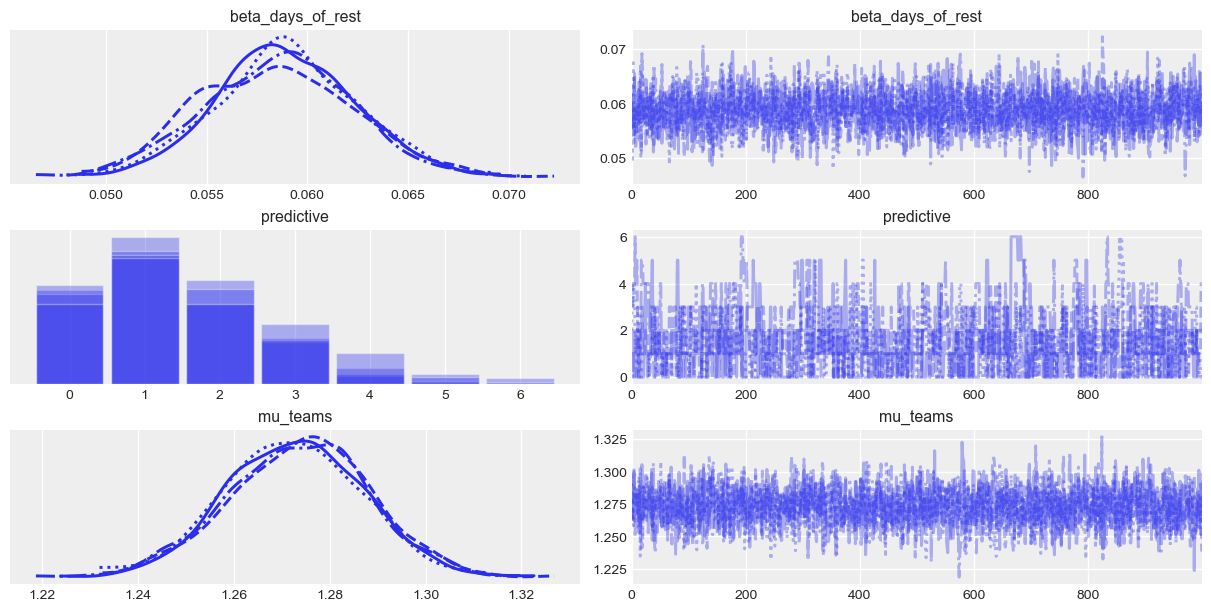

In [10]:
az.plot_trace(trace_pooled)

### posterior predictive

In [11]:
post_pooled = az.extract(trace_pooled.posterior)

#posterior samples
mu = post_pooled.mu_teams.values

y_new = np.zeros(len(mu))
for i, current_mu in enumerate(mu):
        y_new[i] = np.random.poisson(lam = mu[i])
        

print('summary of predictive distribution: \n')
pd.DataFrame(y_new).describe(percentiles=[0.025, 0.975])

summary of predictive distribution: 



,0
count,4000.000000
mean,1.290000
std,1.151404
min,0.000000
2.5%,0.000000
50%,1.000000
97.5%,4.000000
max,7.000000


In [12]:
az.summary(trace_pooled)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_days_of_rest,0.059,0.004,0.052,0.065,0.000,0.000,2348.0,2471.0,1.00
predictive,1.465,1.236,0.000,4.000,0.051,0.041,643.0,488.0,1.01
mu_teams,1.273,0.014,1.247,1.302,0.000,0.000,2204.0,2094.0,1.00


<AxesSubplot: title={'center': 'beta_days_of_rest'}>

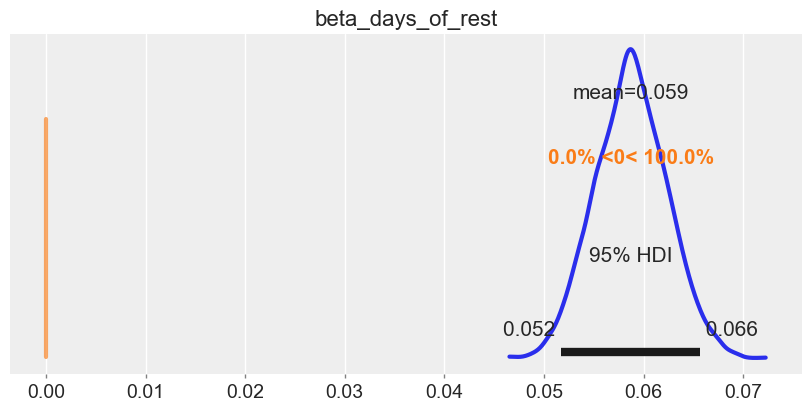

In [13]:
az.plot_posterior(trace_pooled, var_names="beta_days_of_rest", ref_val=0, hdi_prob=0.95)

The beta_days_of_rest parameter being significantly different from zero suggests that the number of rest days does have an influence on the number of goals, at least according to the model. The confidence interval (HDI) for this parameter does not include zero, which generally indicates that the effect is statistically significant.

The model suggests that rest days are a relevant factor in predicting goals, but the real-world importance of this finding may vary. 

The mean of beta_days_of_rest is 0.059 with a standard deviation of 0.004, which could imply that for each additional day of rest, the expected number of goals increases by approximately 0.059.

# Unpooled model

In [14]:
n_teams = hockey_df['Home'].nunique() 
teams = hockey_df['Home'].unique()

hcl_code = np.unique(hockey_df['home_team_code'][hockey_df['Home']=='HC Lugano']).item()
hcap_code = np.unique(hockey_df['home_team_code'][hockey_df['Home']=='HC Ambri-Piotta']).item()

print('games from HCL: ', np.sum(hockey_df['Home'] == 'HC Lugano'))
print('games from HCAP: ', np.sum(hockey_df['Home'] == 'HC Ambri-Piotta'))

games from HCL:  416
games from HCAP:  392


In [15]:
teams

array(['EHC Biel-Bienne', 'EHC Kloten', 'EV Zug', 'Fribourg-Gottéron',
       'Genève-Servette HC', 'HC Ajoie', 'HC Ambri-Piotta', 'HC Davos',
       'HC Lugano', 'Lausanne HC', 'SC Bern', 'SC Langenthal',
       'SC Rapperswil-Jona Lakers', 'SCL Tigers', 'ZSC Lions'],
      dtype=object)

In [16]:

with pm.Model() as unpooled_model:
    # Priors for team effects
    mu_teams = pm.Gamma('mu_teams', alpha, beta, shape=n_teams)

    # Prior for the days of rest effect
    beta_days_of_rest = pm.Normal('beta_days_of_rest', mu=0, sigma=1)

    # Expected mean goals, influenced by days of rest
    expected_goals = mu_teams[flattened_df['team_code'].values] + beta_days_of_rest * flattened_df['days_of_rest'].values

    # Likelihood
    y = pm.Poisson('y', mu=expected_goals, observed=flattened_df['Goals'])
    
    # Predictive distribution for a specific team and a specific number of days of rest
    pred_specific_team = pm.Poisson('predictive', mu=mu_teams[hcl_code] + beta_days_of_rest * avg_days_of_rest)
    
    # Sampling
    trace_unpooled = pm.sample(init="adapt_diag", return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [beta_days_of_rest, mu_teams]
>Metropolis: [predictive]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
The number of effective samples is smaller than 25% for some parameters.


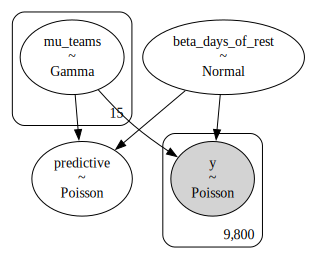

In [17]:
pm.model_to_graphviz(unpooled_model)

[Text(0, 0.0, 'Genève-Servette HC'),
 Text(0, 0.825, 'Fribourg-Gottéron'),
 Text(0, 1.65, 'EV Zug'),
 Text(0, 2.4749999999999996, 'EHC Kloten'),
 Text(0, 3.3, 'EHC Biel-Bienne')]

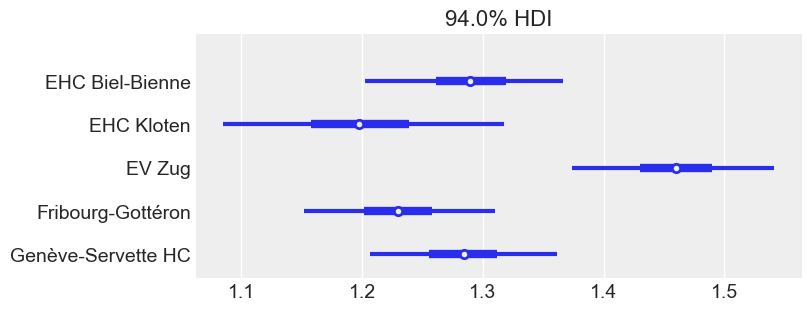

In [18]:
import arviz as az

# Convert PyMC3 trace to an arviz InferenceData object (if it's not already)
if not isinstance(trace_unpooled, az.InferenceData):
    trace_unpooled = az.from_pymc3(trace_unpooled)


# Plot the forest plot for the first 5 teams only
axes = az.plot_forest(trace_unpooled, 
               var_names=["mu_teams"], 
               combined=True, 
               coords={"mu_teams_dim_0": range(5)},  # Only the first 5 teams
               figsize=(8, 3))

axes[0].set_yticklabels(teams[:5][::-1])

array([[<AxesSubplot: title={'center': 'beta_days_of_rest'}>,
        <AxesSubplot: title={'center': 'beta_days_of_rest'}>],
       [<AxesSubplot: title={'center': 'predictive'}>,
        <AxesSubplot: title={'center': 'predictive'}>],
       [<AxesSubplot: title={'center': 'mu_teams'}>,
        <AxesSubplot: title={'center': 'mu_teams'}>]], dtype=object)

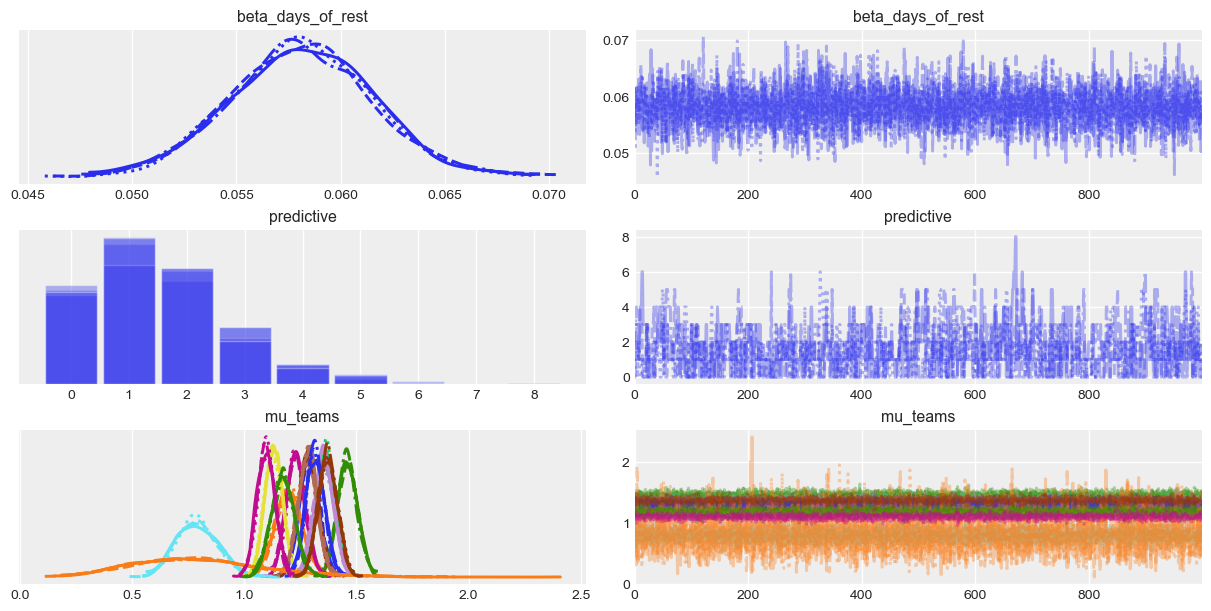

In [19]:
az.plot_trace(trace_unpooled)

In [20]:
posterior = trace_unpooled.posterior.assign_coords(mu_teams_dim_0=teams)
az.summary(posterior).head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_days_of_rest,0.058,0.003,0.051,0.064,0.000,0.000,4967.0,3454.0,1.0
predictive,1.521,1.238,0.000,4.000,0.046,0.032,742.0,952.0,1.0
mu_teams[EHC Biel-Bienne],1.291,0.043,1.203,1.366,0.001,0.000,6356.0,3160.0,1.0
mu_teams[EHC Kloten],1.199,0.062,1.085,1.317,0.001,0.001,6481.0,2877.0,1.0
mu_teams[EV Zug],1.460,0.044,1.374,1.541,0.001,0.000,6360.0,3304.0,1.0


<AxesSubplot: title={'center': 'beta_days_of_rest'}>

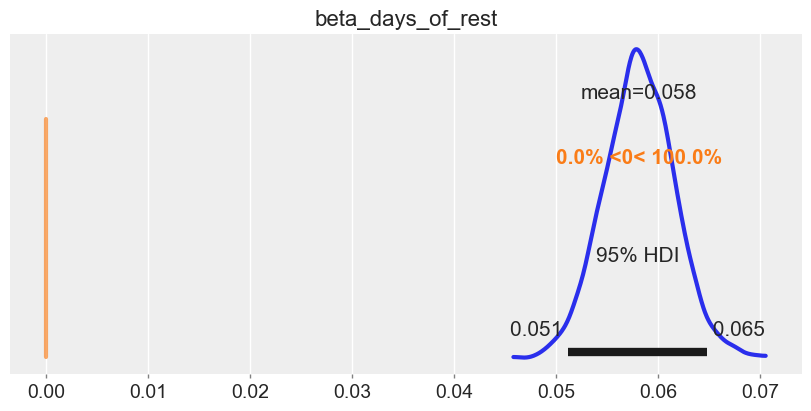

In [21]:
az.plot_posterior(trace_unpooled, var_names="beta_days_of_rest", ref_val=0, hdi_prob=0.95)

As the pooled model, the unpooled also does not include 0 in the HDI, pointing towards the same idea that the rest days are significant in the end result of the game (at least statistically).

# Hierarchical

In [22]:
with pm.Model() as hierarchical_model:
    
    # Priors for global model parameters
    mu_global = pm.Gamma('mu_global', alpha, beta)
    
    # Hierarchical beta to control spread of team means around the global mean
    beta_global = pm.HalfCauchy('beta_global', beta=1)
    
    # Priors for team effects
    mu_teams = pm.Gamma('mu_teams', mu_global, beta_global, shape=n_teams)

    # Prior for the days of rest effect
    beta_days_of_rest = pm.Normal('beta_days_of_rest', mu=0, sigma=1)

    # Expected mean goals, influenced by days of rest
    expected_goals = mu_teams[flattened_df['team_code'].values] + beta_days_of_rest * flattened_df['days_of_rest'].values

    # Likelihood
    y = pm.Poisson('y', mu=expected_goals, observed=flattened_df['Goals'])
    
    pred_specific_team = pm.Poisson('predictive', mu=mu_teams[hcl_code] + beta_days_of_rest * avg_days_of_rest)

    # Sampling
    trace_hierarchical = pm.sample(init="adapt_diag", return_inferencedata=True)
    

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [beta_days_of_rest, mu_teams, beta_global, mu_global]
>Metropolis: [predictive]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


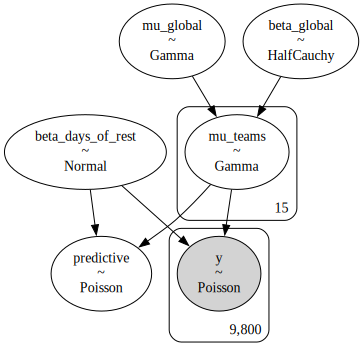

In [23]:
pm.model_to_graphviz(hierarchical_model)

In [24]:
posterior_unp = trace_unpooled.posterior.assign_coords(mu_teams_dim_0=teams)
posterior_hier = trace_hierarchical.posterior.assign_coords(mu_teams_dim_0=teams)

Text(0.5, 0, 'mean goals')

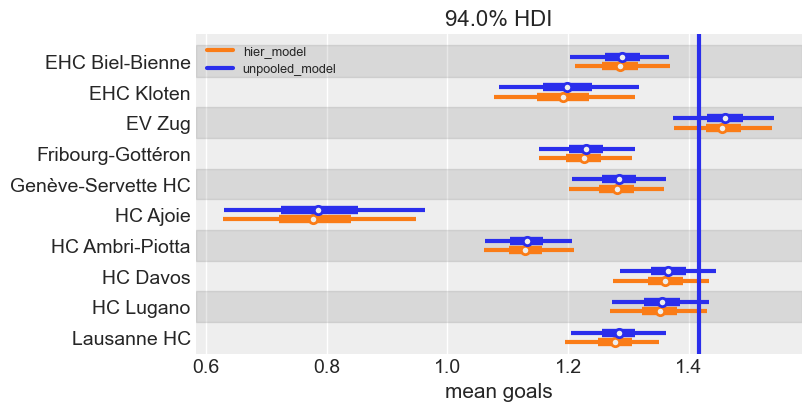

In [25]:
# Convert PyMC3 trace to an arviz InferenceData object (if it's not already)
if not isinstance(trace_unpooled, az.InferenceData):
    trace_unpooled = az.from_pymc3(trace_unpooled)
    trace_hierarchical = az.from_pymc3(trace_hierarchical)


# Plot the forest plot for the first 5 teams only
axes = az.plot_forest([trace_unpooled, trace_hierarchical],
                    model_names = ['unpooled_model', 'hier_model'],
                    var_names=["mu_teams"], 
                    combined=True, 
                    coords={"mu_teams_dim_0": range(10)},  # Only the first 5 teams
                    figsize=(8, 4),
                    )

axes[0].set_yticklabels(teams[:10][::-1])

grand_mean = flattened_df["Goals"].mean()
axes[0].axvline(x=grand_mean)
plt.xlabel("mean goals")

array([[<AxesSubplot: title={'center': 'beta_days_of_rest'}>,
        <AxesSubplot: title={'center': 'beta_days_of_rest'}>],
       [<AxesSubplot: title={'center': 'predictive'}>,
        <AxesSubplot: title={'center': 'predictive'}>],
       [<AxesSubplot: title={'center': 'mu_global'}>,
        <AxesSubplot: title={'center': 'mu_global'}>],
       [<AxesSubplot: title={'center': 'beta_global'}>,
        <AxesSubplot: title={'center': 'beta_global'}>],
       [<AxesSubplot: title={'center': 'mu_teams'}>,
        <AxesSubplot: title={'center': 'mu_teams'}>]], dtype=object)

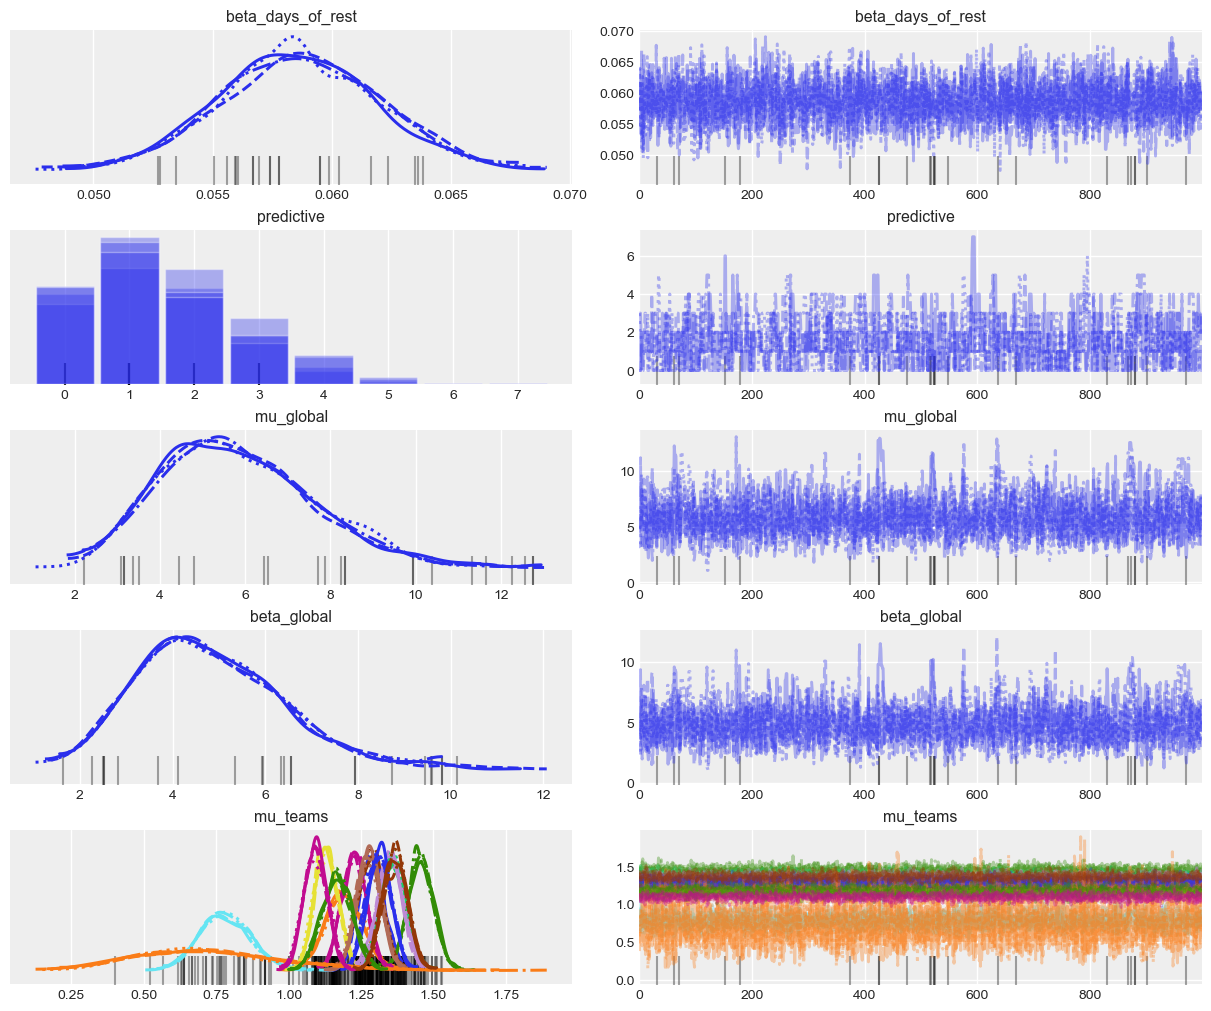

In [26]:
az.plot_trace(trace_hierarchical)

In [27]:
az.summary(trace_hierarchical).head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_days_of_rest,0.059,0.003,0.052,0.065,0.000,0.000,3936.0,2968.0,1.0
predictive,1.484,1.208,0.000,4.000,0.041,0.030,916.0,963.0,1.0
mu_global,5.869,1.881,2.709,9.476,0.050,0.038,1587.0,1041.0,1.0
beta_global,4.832,1.626,2.067,7.943,0.042,0.032,1612.0,1183.0,1.0
mu_teams[0],1.286,0.043,1.210,1.369,0.001,0.000,4376.0,2519.0,1.0


<AxesSubplot: title={'center': 'beta_days_of_rest'}>

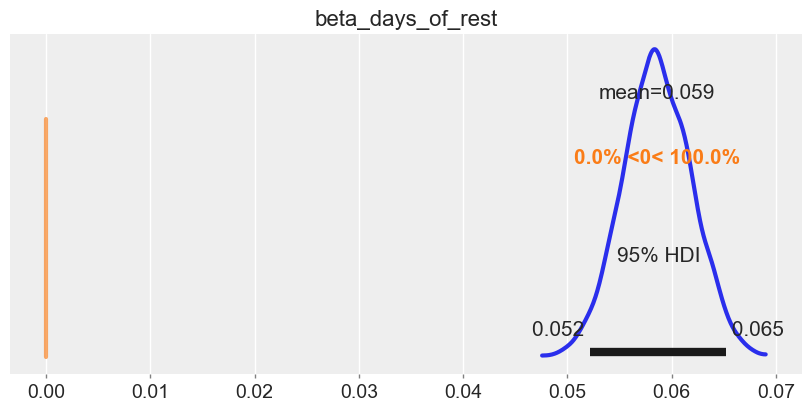

In [28]:
az.plot_posterior(trace_hierarchical, var_names="beta_days_of_rest", ref_val=0, hdi_prob=0.95)

# WAIC

In [29]:
pool_waic = az.waic(trace_pooled)
unpool_waic = az.waic(trace_unpooled)
hier_waic = az.waic(trace_hierarchical)

print(pool_waic)
print(unpool_waic)
print(hier_waic)


/Users/christian/miniforge3/envs/bda/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/christian/miniforge3/envs/bda/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 9800 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -18756.25   136.91
p_waic       19.89        -

There has been a warning during the calculation. Please check the results.
Computed from 4000 posterior samples and 9800 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -18728.07   135.57
p_waic       50.01        -

There has been a warning during the calculation. Please check the results.
Computed from 4000 posterior samples and 9800 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -18727.04   136.12
p_waic       48.83        -

There has been a warning during the calculation. Please check the results.


/Users/christian/miniforge3/envs/bda/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [30]:
comp_df = az.compare({'pooled': trace_pooled, 'unpooled': trace_unpooled,  'hierarchical': trace_hierarchical}, ic='waic')
comp_df

/Users/christian/miniforge3/envs/bda/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/christian/miniforge3/envs/bda/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/christian/miniforge3/envs/bda/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
hierarchical,0,-18727.038614,48.830807,0.000000,0.646803,136.120252,0.000000,True,log
unpooled,1,-18728.065601,50.008411,1.026987,0.000000,135.568195,0.725993,True,log
pooled,2,-18756.250402,19.886229,29.211788,0.353197,136.910453,14.603462,True,log


<AxesSubplot: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_waic (log)', ylabel='ranked models'>

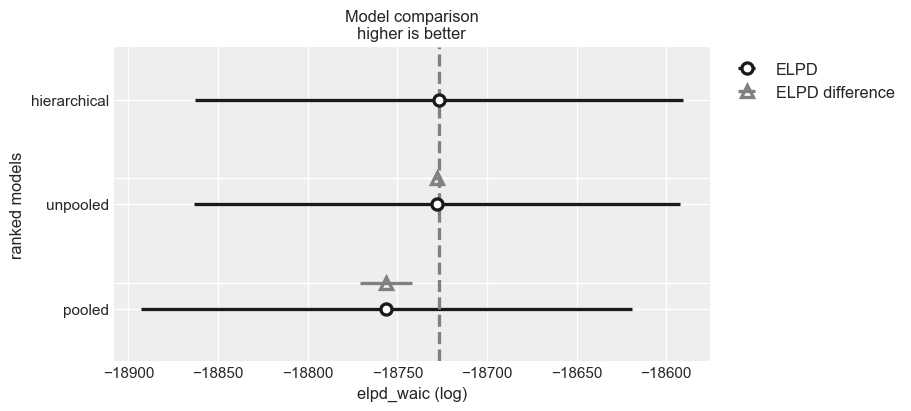

In [31]:
az.plot_compare(comp_df, figsize=(9,4), textsize=11)

The unpooled model is ranked first, vey similar to the hierarchical

## Prediction for a novel team

In [47]:
#prediction for a novel artist
post_hier = az.extract(trace_hierarchical.posterior)

#posterior parameters of the population
mu_population = post_hier.mu_global.values
beta_population = post_hier.beta_global.values

theta = 1 / beta_population  # scale

mu_new_team  = np.zeros(len(mu_population))

for i, current_mu in enumerate(mu_population):
        mu_new_team[i] = np.random.gamma(mu_population[i], theta[i])

#now we have the distribution for the mean of the novel artist.
#we thus compute the distribution for its next song
days_of_rest = post_hier.beta_days_of_rest.values
goals_song_new_team  = np.zeros(len(days_of_rest))

for i, current_mu in enumerate(mu_population):
        goals_song_new_team[i] = np.random.poisson(lam = mu_new_team[i])

pd.DataFrame(goals_song_new_team).describe(percentiles=[0.025, 0.975])        

,0
count,4000.000000
mean,1.250500
std,1.257834
min,0.000000
2.5%,0.000000
50%,1.000000
97.5%,4.000000
max,9.000000


In [48]:
#prediction for a novel artist
post_hier = az.extract(trace_hierarchical.posterior)

#posterior parameters of the population
mu_population = post_hier.mu_global.values
beta_population = post_hier.beta_global.values
theta = 1 / beta_population  # scale

mu_new_team  = np.zeros(len(mu_population))

for i, current_mu in enumerate(mu_population):
        mu_new_team[i] = np.random.gamma(mu_population[i], theta[i])
        
# Create an array to hold the predicted goals, which is the same length as your posteriors
goals_new_team  = np.zeros(len(mu_new_team))

# Define a value for the average days of rest for this new team
avg_days_of_rest_for_new_team = flattened_df["days_of_rest"].mean()
days_of_rest = flattened_df["days_of_rest"]

# Iterate over each draw from the posterior
for i in range(len(mu_new_team)):
    # Compute the expected number of goals for this draw, adding in the effect for days_of_rest
    expected_goals = mu_new_team[i] + days_of_rest[i] * avg_days_of_rest_for_new_team
    # Generate a Poisson random variable based on this expected number of goals
    goals_new_team[i] = np.random.poisson(lam=expected_goals)

# Summarize the distribution of goals for the new team
summary = pd.DataFrame(goals_new_team).describe(percentiles=[0.025, 0.975])
summary

,0
count,4000.000000
mean,7.207250
std,35.693344
min,0.000000
2.5%,0.000000
50%,2.000000
97.5%,25.025000
max,559.000000


For testing we are comparing the novel team predictions with and without the rest days linear combination. The one that includes it seem to be quite bad at predicting, while the simpler one seems to be more conherent with previous results.